# Project

In [146]:
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 100

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

from sklearn.manifold import TSNE
from sklearn.model_selection import KFold

os.chdir('C:/Users/RH/Documents/GeekBrains/DataScience course/Numpy, Pandas, Sklearn/Project')

df_train = pd.read_csv('train.csv', sep = ',', encoding = 'utf8')
df_test = pd.read_csv('test.csv', sep = ',', encoding = 'utf8')

Очистка и подготовка данных

In [147]:
#исправляем орфографическую ошибку
df_train = df_train.rename(columns={"Helthcare_2": "Healthcare_2"}) 
df_test = df_test.rename(columns={"Helthcare_2": "Healthcare_2"})

#заменяем нереалистичные данные
#df_train['HouseYear'].sort_values(ascending=False)
df_train['HouseYear'].replace({4968: 1968}, inplace=True) 

#заменяем буквы на цифры в категориальных переменных
df_train['Ecology_2'].replace({'A': 0, 'B': 1}, inplace=True)
df_train['Ecology_3'].replace({'A': 0, 'B': 1}, inplace=True)
df_train['Shops_2'].replace({'A': 0, 'B': 1}, inplace=True)

df_test['Ecology_2'].replace({'A': 0, 'B': 1}, inplace=True)
df_test['Ecology_3'].replace({'A': 0, 'B': 1}, inplace=True)
df_test['Shops_2'].replace({'A': 0, 'B': 1}, inplace=True)

#удаляем кривые данные
df_train = df_train.drop(df_train[df_train['HouseYear'] == 20052011].index)
df_train = df_train.drop(df_train[df_train['KitchenSquare'] >= 1000].index)
df_train = df_train.drop(df_train[df_train['LifeSquare'] >= 4000].index)
df_train = df_train.drop(df_train[df_train['Square'] >= 250].index)

#заменяем нереалистичные по площади кухни
df_test['KitchenSquare'] = np.where(df_test['KitchenSquare'] >= 200, 
                                    np.median(df_test['KitchenSquare']), df_test['KitchenSquare'])
df_train['KitchenSquare'] = np.where((df_train['KitchenSquare']/df_train['Square']>=0.85) | (df_train['KitchenSquare'] <=3), 
                                     0, df_train['KitchenSquare'])
df_test['KitchenSquare'] = np.where((df_test['KitchenSquare']/df_test['Square']>=0.85) | (df_test['KitchenSquare'] <=3), 
                                    0, df_test['KitchenSquare'])

#создаем доп переменную - одноэтажный дом
df_train['1FloorHouse'] = np.where((df_train['HouseFloor']<=1) & (df_train['Floor']<=1), 1, 0)
df_test['1FloorHouse'] = np.where((df_test['HouseFloor']<=1) & (df_test['Floor']<=1), 1, 0)

#создаем доп переменную - дом от 2 этажей, и живет на 1 этаже
df_train['1Floor'] = np.where((df_train['HouseFloor']>1) & (df_train['Floor']<=1), 1, 0)
df_test['1Floor'] = np.where((df_test['HouseFloor']>1) & (df_test['Floor']<=1), 1, 0)

#создаем доп переменную - студия, если площадь кухни = 0
df_train['Studio'] = np.where(df_train['KitchenSquare'] == 0, 1, 0)
df_test['Studio'] = np.where(df_test['KitchenSquare'] == 0, 1, 0)

#заполняем пропуски Healthcare_1
df_train['Healthcare_1'] = np.where(np.isnan(df_train['Healthcare_1']), 
                                    np.mean(df_train['Healthcare_1']), df_train['Healthcare_1'])
df_test['Healthcare_1'] = np.where(np.isnan(df_test['Healthcare_1']), 
                                   np.mean(df_test['Healthcare_1']), df_test['Healthcare_1'])

#заменяем квартиры где 0 комнат или слишком много комнат на медиану
df_train['Rooms'] = np.where((df_train['Rooms'] ==0) | (df_train['Rooms'] >=6), 
                             int(np.median(df_train['Rooms'])), df_train['Rooms'])
df_test['Rooms'] = np.where((df_test['Rooms'] ==0) | (df_test['Rooms'] >6), 
                            int(np.median(df_test['Rooms'])), df_test['Rooms'])

#заменяем квартиры где площадь очень маленькая, на медиану
df_train['Square'] = np.where(df_train['Square'] <= 10, np.median(df_train['Square']), df_train['Square'])
df_test['Square'] = np.where(df_test['Square'] <= 10, np.median(df_test['Square']), df_test['Square'])

#заменяем этажность дома где слишком большая, на медиану
df_train['HouseFloor'] = np.where(df_train['HouseFloor'] >= 75, np.median(df_train['HouseFloor']), df_train['HouseFloor'])
df_test['HouseFloor'] = np.where(df_test['HouseFloor'] >= 75, np.median(df_test['HouseFloor']), df_test['HouseFloor'])
df_test['Floor'] = np.where(df_test['Floor'] >= 75, np.median(df_test['Floor']), df_test['Floor'])


#создаем новую переменную, этаж относительно этажности дома и заменяем там где этаж строго больше этажности, на медиану
df_train['RatioFloor'] = df_train['Floor']/df_train['HouseFloor']
df_test['RatioFloor'] = df_test['Floor']/df_test['HouseFloor']
df_train['RatioFloor'] = np.where(df_train['RatioFloor'] > 1, np.median(df_train['RatioFloor']), df_train['RatioFloor'])
df_test['RatioFloor'] = np.where(df_test['RatioFloor'] > 1, np.median(df_test['RatioFloor']), df_test['RatioFloor'])


In [148]:
#df_train.shape
#df_train.isna().sum()
#df_train.describe
df_train.head(10)


Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            0.0      8   
3   5809          58    2.0  53.352981   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   
5  12915          59    3.0  80.384479   46.683720           12.0      5   
6  14549         154    2.0  62.254114   37.160377            7.0      3   
7  11993          74    2.0  80.312926         NaN            0.0     14   
8   5172           1    2.0  64.511437         NaN            0.0      9   
9   8649          23    1.0  46.461409   18.915552            8.0     13   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
0         9.0       1969   0.089040          1          1        33      7976   
1         9.0       1978   0.000070          1          1        46     10309   
2        12.0       1968   0.049637          1          1        34      7759   
3        17.0       1977   0.437885          1          1        23      5735   
4        12.0       1976   0.012339          1          1        35      5776   
5        17.0       2011   0.309479          1          1        35      7715   
6         5.0       1960   0.460556          1          1        20      4386   
7         0.0       1977   0.075779          1          1         6      1437   
8        17.0       1977   0.007122          1          1         1       264   
9        17.0       2014   0.075779          1          1         6      1437   

   Social_3  Healthcare_1  Healthcare_2  Shops_1  Shops_2          Price  \
0         5   1142.839299             0       11        1  184966.930730   
1         1    240.000000             1       16        1  300009.450063   
2         0    229.000000             1        3        1  220925.908524   
3         3   1084.000000             0        5        1  175616.227217   
4         1   2078.000000             2        4        1  150226.531644   
5         4    990.000000             0        6        1  215898.447742   
6        14   1142.839299             1        5        1  296021.204377   
7         3   1142.839299             0        2        1  221244.156664   
8         0   1142.839299             0        1        1  229102.795999   
9         3   1142.839299             0        2        1   95380.220993   

   1FloorHouse  1Floor  Studio  RatioFloor  
0            0       0       0    0.777778  
1            0       0       0    0.777778  
2            0       0       1    0.666667  
3            0       0       0    0.470588  
4            0       0       0    0.916667  
5            0       0       0    0.294118  
6            0       0       0    0.600000  
7            0       0       1    0.687500  
8            0       0       1    0.529412  
9            0       0       0    0.764706

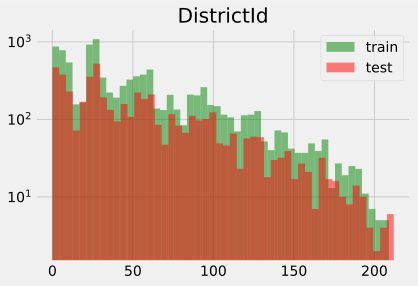

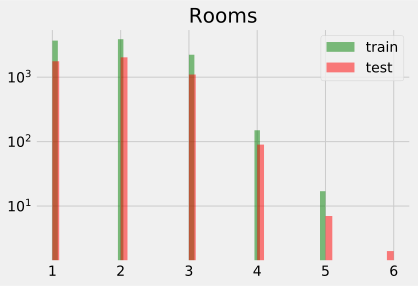

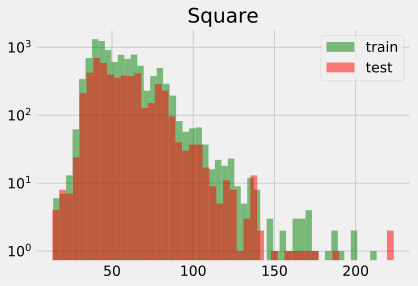

C:\Users\RH\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\RH\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


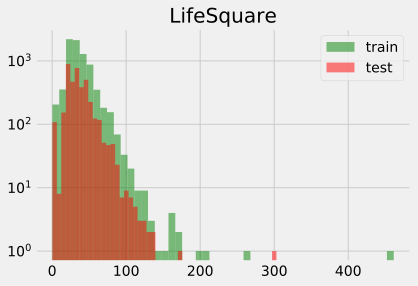

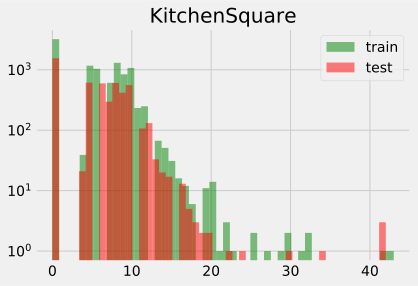

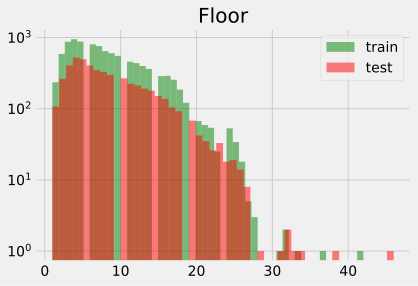

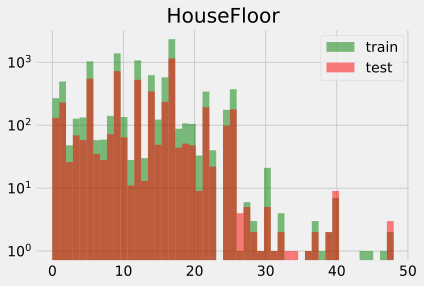

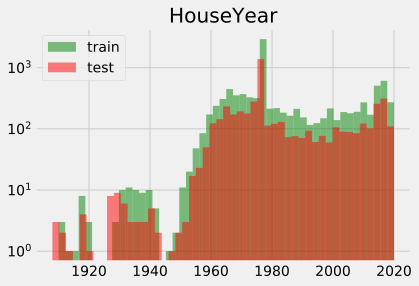

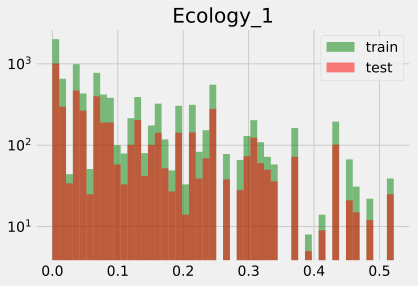

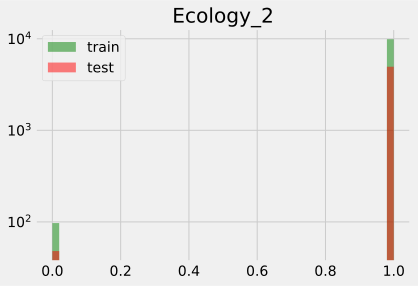

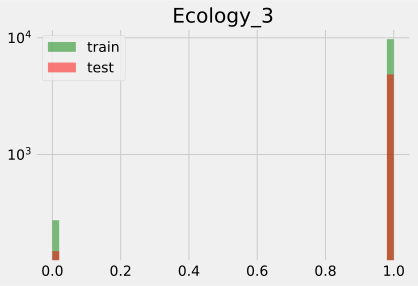

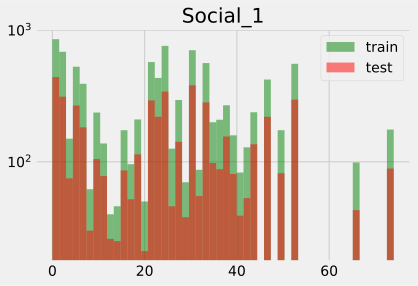

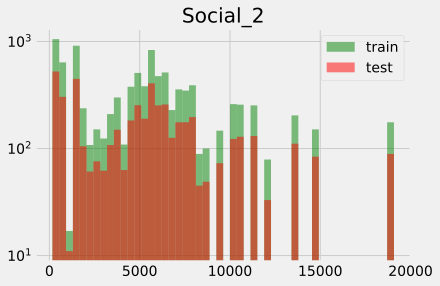

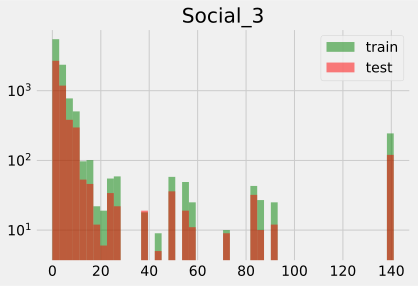

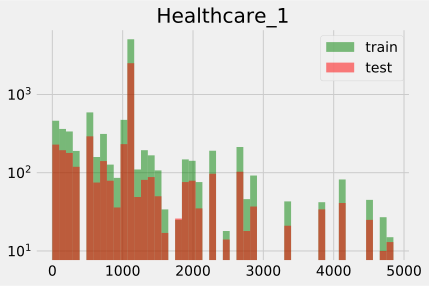

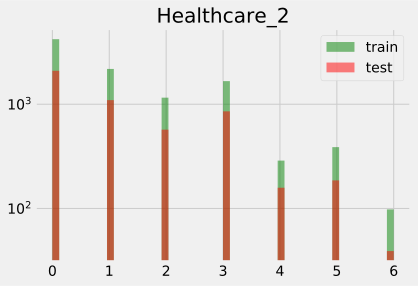

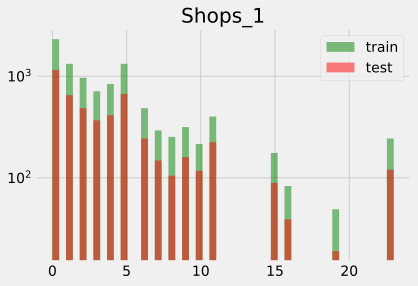

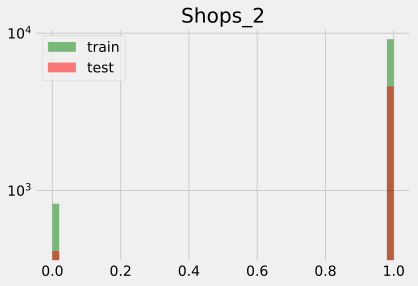

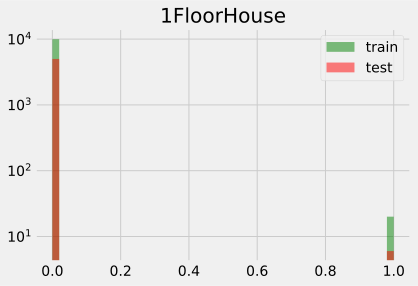

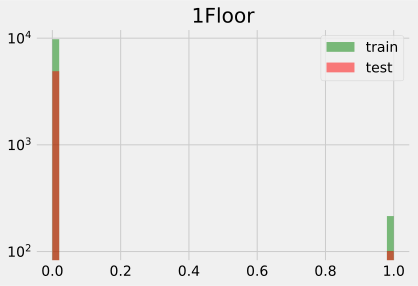

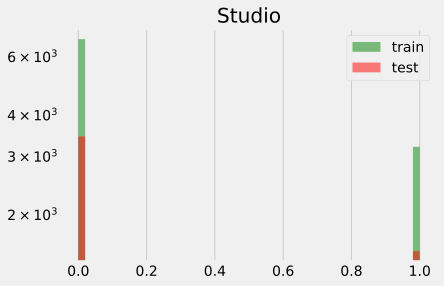

In [134]:
def compare(feature):

    plt.hist(df_train[feature], bins=50, alpha  = 0.5, color = 'green', label='train')
    plt.hist(df_test[feature], bins=50, alpha  = 0.5, color = 'red', label='test')
    plt.title(feature)
    plt.legend()
    plt.yscale('log')
    plt.show()

for i in range(1, len(df_test.columns)):
    compare(df_test.columns[i])

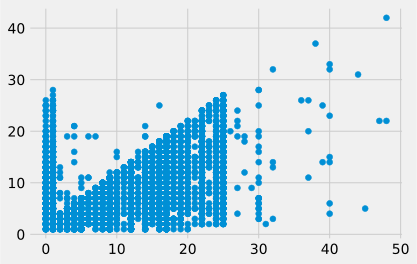

In [145]:
plt.scatter(df_train['HouseFloor'], df_train['Floor'])
plt.show()


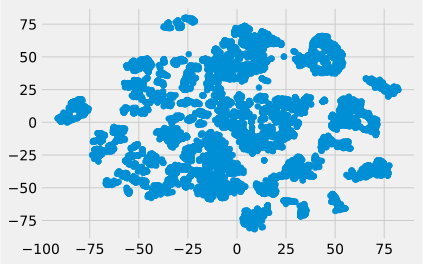

In [136]:

# , 'Shops_2' 'Ecology_2', 'Ecology_3',
features = ['Square', 'Floor', 'Rooms', 'HouseYear', 'Ecology_1',  'Social_1', 'Social_2', 'Social_2', 
         'Healthcare_2', 'Shops_1']

x_sc = scaler.fit(df_train[features].values)
x_train_sc = x_sc.transform(df_train[features].values)

tsne = TSNE(n_components=2, perplexity = 45, learning_rate=150, random_state=100)
x_train_tsne = tsne.fit_transform(x_train_sc)

plt.scatter(x_train_tsne[:, 0], x_train_tsne[:, 1])
plt.show()

In [230]:


"""
#df_train['Ecology_2'] = df_train['Ecology_2'].astype('category')
#df_train['Ecology_3'] = df_train['Ecology_3'].astype('category')
#df_train['Shops_2'] = df_train['Shops_2'].astype('category')


category = ['Ecology_2', 'Ecology_3', 'Shops_2']


from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

x_ohe = ohe.fit(df_train[category])
x_ohe.categories_
x_ohe.get_feature_names(['Ecology_2', 'Ecology_3', 'Shops_2'])
x_train_ohe = x_ohe.transform(df_train[category]).toarray() 

#concatenated_data = pd.concat([df_train, x_train_ohe], axis=1)
x_train_ohe = pd.DataFrame(x_train_ohe, index=df_train.index, 
                           columns = x_ohe.get_feature_names(['Ecology_2', 'Ecology_3', 'Shops_2']))
x_train_ohe.head(5)
"""


"\n#df_train['Ecology_2'] = df_train['Ecology_2'].astype('category')\n#df_train['Ecology_3'] = df_train['Ecology_3'].astype('category')\n#df_train['Shops_2'] = df_train['Shops_2'].astype('category')\n\n\ncategory = ['Ecology_2', 'Ecology_3', 'Shops_2']\n\n\nfrom sklearn.preprocessing import OneHotEncoder\nohe = OneHotEncoder()\n\nx_ohe = ohe.fit(df_train[category])\nx_ohe.categories_\nx_ohe.get_feature_names(['Ecology_2', 'Ecology_3', 'Shops_2'])\nx_train_ohe = x_ohe.transform(df_train[category]).toarray() \n\n#concatenated_data = pd.concat([df_train, x_train_ohe], axis=1)\nx_train_ohe = pd.DataFrame(x_train_ohe, index=df_train.index, \n                           columns = x_ohe.get_feature_names(['Ecology_2', 'Ecology_3', 'Shops_2']))\nx_train_ohe.head(5)\n"

Подготовка модели

In [159]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

target = 'Price'
# , 'Shops_2', 'Ecology_2', 'Ecology_3', '1FloorHouse', '1Floor', 'Studio' , 'HouseFloor' 'RatioFloor',
features = ['DistrictId', 'Square',  'KitchenSquare', 'Floor', 'Rooms', 'HouseYear', 'Ecology_1', 
            'Social_1', 'Social_2', 'Social_2', 'Healthcare_1', 'Healthcare_2', 'Shops_1',  'RatioFloor', 'HouseFloor'        
            ]

y = df_train[target].values.ravel()
x = df_train[features].values

param_grid  = {'max_depth':[16, 17, 18, 19, 20],
                'min_samples_split':[2],
                'min_samples_leaf':[1],
              'n_estimators':[300]}

rf = RandomForestRegressor(  criterion='mse',                           
                             min_weight_fraction_leaf=0.0,
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             min_impurity_split=None,
                             bootstrap=True,
                             oob_score=False,
                             random_state=1,
                             verbose=0,
                             warm_start=False)

grid = GridSearchCV(rf, param_grid = param_grid, cv = 10, 
                    scoring = 'r2') 

grid.fit(x, y)

print(grid.best_estimator_)

print(grid.best_score_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=19,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)
0.7310423667828536


In [160]:
model = grid.best_estimator_.fit(x, y)
feach_import = np.vstack((features, np.round(model.feature_importances_,2))).T
feach_import

array([['DistrictId', '0.06'],
       ['Square', '0.4'],
       ['KitchenSquare', '0.03'],
       ['Floor', '0.03'],
       ['Rooms', '0.08'],
       ['HouseYear', '0.04'],
       ['Ecology_1', '0.04'],
       ['Social_1', '0.1'],
       ['Social_2', '0.06'],
       ['Social_2', '0.05'],
       ['Healthcare_1', '0.04'],
       ['Healthcare_2', '0.01'],
       ['Shops_1', '0.02'],
       ['RatioFloor', '0.02'],
       ['HouseFloor', '0.03']], dtype='<U32')

Прогноз

In [161]:
x_test = df_test[features].values
y_test = np.round(model.predict(x_test),1)

output = np.vstack([df_test['Id'].values, y_test]).T

output = pd.DataFrame(output)
output.columns = ['Id', 'Price']
output['Id'] = pd.to_numeric(output['Id'], downcast='integer')

output.to_csv('output.csv', index=False, sep= ',')

In [104]:
train_room_stat = df_train.groupby(['Rooms']).agg({'Square':['count', 'mean', 'min', 'max']})
train_room_stat

Square                                   
       count        mean        min         max
Rooms                                          
1.0     3701   41.225797   1.136859  174.649522
2.0     3890   56.546738   2.377248  212.932361
3.0     2234   76.901089   4.390331  190.857689
4.0      150   98.377544  44.128947  200.334539
5.0       17  113.613157  39.906082  198.930182

In [112]:
df_test['Square'].sort_values(ascending=True).head(50)

66       1.378543
4902     1.975769
4490     2.372101
608      2.645046
4713     2.900586
4540     4.967143
1165     5.100672
837      5.647458
3697    13.305531
2       13.597819
2744    16.319015
1441    17.273699
1195    18.149267
557     19.043894
2895    19.166821
2480    20.011215
58      21.452899
3656    21.511539
3435    21.588919
4457    21.674694
3748    21.881589
2647    22.049872
1340    23.681687
282     24.170511
1573    25.244171
627     25.329567
2638    25.340574
2424    25.956829
4234    26.719723
4746    27.156019
1436    27.658462
1141    27.839145
1437    28.025001
2710    28.240534
3229    28.571190
2373    28.713676
146     28.767353
1091    28.982655
2563    29.080105
2163    29.096847
371     29.107091
1600    29.249108
4832    29.480296
4800    29.570802
2416    29.583540
3338    29.585758
4837    29.666895
1960    29.708662
1807    29.744373
3679    29.933936
Name: Square, dtype: float64